# Modeling Thermodynamic Cycles in Python

This exercise simulates a Rankine power plant cycle using the TESPy package in Python. TESPy stands for "Thermal Engineering Systems in Python" and provides a simulation toolkit for thermal engineering plants such as power
plants, district heating systems or heat pumps. It is an external extension
module within the Open Energy Modelling Framework `oemof <https://oemof.org/>`_
and can be used as a standalone package.

Examples and documentation in [TESPy](https://github.com/oemof/tespy). Find more information
about the modelling feature in the respective [online documentation](https://tespy.readthedocs.io/en/main/).

BibTeX citation:

    @article{Witte2020,
        doi = {10.21105/joss.02178},
        year = {2020},
        publisher = {The Open Journal},
        volume = {5},
        number = {49},
        pages = {2178},
        author = {Francesco Witte and Ilja Tuschy},
        title = {{TESPy}: {T}hermal {E}ngineering {S}ystems in {P}ython},
        journal = {Journal of Open Source Software}
    }

## Authors

The authors of this exercise are:

- Amedeo Ceruti
- Urbano Tataranni
- Hassan Hussein
- Jihad Jundi

## This exercise

This exercise details the steps and provides the necessary explanations for simulating a Rankine power plant.

### Basic Rankine Cycle

The simulation begins with a basic cycle, and then upgrades it by incorporating a reheat stage. This includes creating a fluid network, configuring the main components such as the cycle closer, pump, condenser, turbine, and heat exchanger, establishing and configuring connections between the components, and setting operational conditions and efficiency parameters. The next step is to solve the thermodynamic model of the basic cycle and analyze the results obtained from the simulation.

### Rankine Cycle with Reheat 

The simulation is then enhanced by implementing a reheat stage in the Rankine cycle. This step involves evaluating the impact of adding reheat on the overall efficiency and performance of the plant.

## Basic Cycle

![Representation of the cycle under examination](figs/Rankine_simple.png)

In [135]:
%pip install tespy
from tespy.networks import Network
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


The Network of our plant is created. All the required components are called from the library and, since a simple Rankine cycles is studied, only 6 components are used. These components are:

- one feed water Pump,
- one Condenser for heat removal,
- one Turbine for extracting work,
- one SimpleHeatExchanger for simulating heat flow from the solar collector system to the working fluid,
- one Source,
- one Sink,
- one CyclerCloser.

The component *CyclerCloser* is used to set the condition of closed system process, because the system of equations describing the system will be overdetermined if a cycle is closed without this component. More information about other component can be consulted in the [online documentation](https://tespy.readthedocs.io/en/main/).

In [136]:
from tespy.components import (
    CycleCloser, Pump, Condenser, Turbine, SimpleHeatExchanger, Source, Sink
)

In [137]:
# create a network object with water as fluid
my_plant = Network()
my_plant.set_attr(T_unit='C', p_unit='bar', h_unit='kJ / kg')

cc = CycleCloser('cycle closer')
sg = SimpleHeatExchanger('steam generator')
mc = Condenser('main condenser')
tu = Turbine('steam turbine')
fp = Pump('feed pump')

cwso = Source('cooling water source')
cwsi = Sink('cooling water sink')

Now we establish connections between the various components of the Rankine cycle using TESpy's logic. The label is used as shown in the figure above.

In [138]:
from tespy.connections import Connection

In [139]:
c1 = Connection(cc, 'out1', tu, 'in1', label='1')
c2 = Connection(tu, 'out1', mc, 'in1', label='2')
c3 = Connection(mc, 'out1', fp, 'in1', label='3')
c4 = Connection(fp, 'out1', sg, 'in1', label='4')
c0 = Connection(sg, 'out1', cc, 'in1', label='0')

my_plant.add_conns(c1, c2, c3, c4, c0)

Additional connections are set up for the cooling water loop through the condenser.

- `c11` connects the outlet of the cooling water source (`cwso`) to the secondary inlet of the main condenser (`mc`).
- `c12` connects the secondary outlet of the main condenser (`mc`) to the inlet of the cooling water sink (`cwsi`).

These connections (`c11` and `c12`) are again added to the network as before.

In [140]:
c11 = Connection(cwso, 'out1', mc, 'in2', label='11')
c12 = Connection(mc, 'out2', cwsi, 'in1', label='12')

my_plant.add_conns(c11, c12)

## The Andasol Power Plant

The Andasol I and II power plants are parabolic through concentrating
solar thermal systems located in southern Spain and built in 2007:

- [Andasol 2 entry in the SolarPACES database](https://solarpaces.nrel.gov/project/andasol-2)
- [General information on the power plant](http://large.stanford.edu/publications/power/references/docs/Andasol1-3engl.pdf)

The original power plant specifications and results are obtained from the following
publication:
- [Andasol-2 Parabolic Trough Steam Ranking Cycle](https://doi.org/10.1016/j.jprocont.2016.01.002)

### 1.1 Read the information about Andasol and fill out the table below?

Use the cited paper.

| Andasol II               | HP turbine   |
|--------------------------|--------------|
| Conditions at the inlet  | P = 104 bar  |
|                          | T = 384 °C   |
|                          | ṁ= 54 kg/s  |
| Conditions at the outlet | P = 0.05 bar |
|                          | T = 30 °C    |

In [141]:
T_tu_in = 384       # temperature turbine inlet
p_tu_in = 104       # pressure turbine inlet
mf = 54             # mass flow
p_tu_out = 0.05     # pressure turbine outlet

T_coo_in = 16       # temperature cooling water in
T_coo_out = 26      # temperature cooling water out

## Setting Attributes in TESpy

Now we transfer the parameters stored in the variables above to the cycle in TESpy.

### Component Attributes

- `mc.set_attr(pr1=1, pr2=1)`: Sets the pressure ratio (`pr1` and `pr2`) for the main condenser (`mc`) to 1, meaning there is no pressure drop across the condenser.
- `sg.set_attr(pr=1)`: Sets the pressure ratio (`pr`) for the steam generator (`sg`) to 1, indicating no pressure drop.
- `tu.set_attr(eta_s=0.80)`: Sets the isentropic efficiency (`eta_s`) of the turbine (`tu`) to 80%.
- `fp.set_attr(eta_s=0.90)`: Sets the isentropic efficiency (`eta_s`) of the feed pump (`fp`) to 90%.


In [142]:
mc.set_attr(pr1=1, pr2=1)  # assume no pressure loss in condenser
sg.set_attr(pr=1)
tu.set_attr(eta_s=0.80)       # Turbine isentropic efficiency
fp.set_attr(eta_s=0.90)         # Feed pump isentropic efficiency

### Connection Attributes

- `c11.set_attr(T=T_coo_in, p=1.2, fluid={'water': 1})`: Sets the temperature (`T`), pressure (`p`), and fluid composition (`fluid`) for connection `c11`. The temperature is set to the cooling water inlet temperature (`T_coo_in`), pressure to 1.2 bar, and the fluid to water.
- `c12.set_attr(T=T_coo_out)`: Sets the temperature (`T`) for connection `c12` to the cooling water outlet temperature (`T_coo_out`).
- `c1.set_attr(T=T_tu_in, p=p_tu_in, m=mf, fluid={'water': 1})`: Sets the temperature (`T`), pressure (`p`), mass flow rate (`m`), and fluid composition (`fluid`) for connection `c1`. The temperature is set to the turbine inlet temperature (`T_tu_in`), pressure to the turbine inlet pressure (`p_tu_in`), mass flow rate to `mf`, and the fluid to water.
- `c2.set_attr(p=p_tu_out)`: Sets the pressure (`p`) for connection `c2` to the turbine outlet pressure (`p_tu_out`).

In [143]:
c11.set_attr(T=T_coo_in, p=1.2, fluid={'water': 1})
c12.set_attr(T=T_coo_out)
c1.set_attr(T=T_tu_in, p=p_tu_in, m=mf, fluid={'water': 1})
c2.set_attr(p=p_tu_out)

### Power bus configuration

Finally, a bus to track the electrical power output of the system is defined by adding components to this bus to account for their contributions to the electrical power generation and consumption.

In [144]:
from tespy.connections import Bus

powergen = Bus("electrical power output")

powergen.add_comps(
    {"comp": tu, "char": 0.98 * 0.95, "base": "component"},     # eff_mecc = 0.98, eff_gen = 0.95
    {"comp": fp, "char": 0.95, "base": "bus"},                          # eff_el = 0.95
)

my_plant.add_busses(powergen)

## Solve the Cycle

In [145]:
my_plant.set_attr(iterinfo=True)
my_plant.solve(mode='design')
# my_plant.print_results()


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.36e+08   | 0 %        | 1.60e+03   | 1.56e+07   | 3.34e+06   | 0.00e+00   | 0.00e+00   
 2     | 7.77e+06   | 0 %        | 3.16e+02   | 2.70e+06   | 1.33e+06   | 0.00e+00   | 0.00e+00   
 3     | 1.30e+06   | 0 %        | 1.25e+02   | 1.29e+06   | 1.37e+05   | 0.00e+00   | 0.00e+00   
 4     | 5.98e+05   | 2 %        | 1.10e+02   | 5.95e+05   | 1.20e+05   | 0.00e+00   | 0.00e+00   
 5     | 2.52e+05   | 6 %        | 9.63e+01   | 2.47e+05   | 1.06e+05   | 0.00e+00   | 0.00e+00   
 6     | 9.25e+04   | 11 %       | 8.42e+01   | 8.30e+04   | 9.24e+04   | 0.00e+00   | 0.00e+00   
 7     | 4.74e+04   | 14 %       | 7.23e+01   | 3.48e+04   | 7.93e+04   | 0.00e+00   | 0.00e+00   
 8     | 2.66e+04   | 17 %       | 5.91e+01   | 1.49e+04   | 6.48e+04   | 0.00e+00   | 0.00e+00   
 9     | 

### Results output

Solving command launched by printing simulation results without information about iteration steps by using *.print_results()*. For better visualisation, the printing procedure is done using dataframe manipulation.

In [146]:
df_turbine = pd.DataFrame([{
    'name': 'steam turbine', 
    'P': tu.P.val, 
    'eta_s': tu.eta_s.val, 
    'pr': tu.pr.val
}])

df_condenser = pd.DataFrame([{
    'name': 'main condenser', 
    'Q': mc.Q.val, 
    'kA': mc.kA.val, 
    'ttd_u': mc.ttd_u.val,
    'ttd_l': mc.ttd_l.val, 
    'pr1': mc.pr1.val, 
    'pr2': mc.pr2.val, 
    'zeta1': mc.zeta1.val, 
    'zeta2': mc.zeta2.val
}])

df_pump = pd.DataFrame([{
    'name': 'feed pump', 
    'P': fp.P.val, 
    'eta_s': fp.eta_s.val, 
    'pr': fp.pr.val
}])

df_generator = pd.DataFrame([{
    'name': 'steam generator', 
    'Q': sg.Q.val, 
    'pr': sg.pr.val, 
    'zeta': sg.zeta.val
}])

df_connections = pd.DataFrame([
    {'label': '1', 'm': c1.m.val, 'p': c1.p.val, 'h': c1.h.val, 'T': c1.T.val},
    {'label': '2', 'm': c2.m.val, 'p': c2.p.val, 'h': c2.h.val, 'T': c2.T.val},
    {'label': '3', 'm': c3.m.val, 'p': c3.p.val, 'h': c3.h.val, 'T': c3.T.val},
    {'label': '4', 'm': c4.m.val, 'p': c4.p.val, 'h': c4.h.val, 'T': c4.T.val},
    {'label': '0', 'm': c0.m.val, 'p': c0.p.val, 'h': c0.h.val, 'T': c0.T.val},
    {'label': '11', 'm': c11.m.val, 'p': c11.p.val, 'h': c11.h.val, 'T': c11.T.val},
    {'label': '12', 'm': c12.m.val, 'p': c12.p.val, 'h': c12.h.val, 'T': c12.T.val}
])

df_buses = pd.DataFrame([
    {'name': 'steam turbine', 'component value': tu.P.val, 'bus value': -4.728e+07, 'efficiency': 9.310e-01},
    {'name': 'feed pump', 'component value': fp.P.val, 'bus value': 6.585e+05, 'efficiency': 9.500e-01},
    {'name': 'total', 'component value': -5.016e+07, 'bus value': -4.662e+07, 'efficiency': None}
])

# Display DataFrames
print("Turbine DataFrame")
print(df_turbine)

print("\nCondenser DataFrame")
print(df_condenser)

print("\nPump DataFrame")
print(df_pump)

print("\nGenerator DataFrame")
print(df_generator)

print("\nConnections DataFrame")
print(df_connections)

print("\nBuses DataFrame")
print(df_buses)

Turbine DataFrame
            name             P  eta_s        pr
0  steam turbine -5.078145e+07    0.8  0.000481

Condenser DataFrame
             name             Q            kA     ttd_u      ttd_l  pr1  pr2  \
0  main condenser -1.057496e+08  9.496378e+06  6.874255  16.874255  1.0  1.0   

   zeta1  zeta2  
0    0.0    0.0  

Pump DataFrame
        name              P  eta_s      pr
0  feed pump  625610.046491    0.9  2080.0

Generator DataFrame
              name             Q   pr  zeta
0  steam generator  1.559055e+08  1.0   0.0

Connections DataFrame
  label            m       p            h           T
0     1    54.000000  104.00  3036.472285  384.000000
1     2    54.000000    0.05  2096.075041   32.874255
2     3    54.000000    0.05   137.748596   32.874255
3     4    54.000000  104.00   149.333967   33.407954
4     0    54.000000  104.00  3036.472285  384.000000
5    11  2527.724589    1.20    67.282579   16.000000
6    12  2527.724589    1.20   109.118477   26.000000

B

## 1.2 Calculate the Efficiency of the Cycle

In [147]:
# Calculate net work output (electrical power generated by the turbine)
W_net = abs(powergen.P.val)  # Taking absolute value to ensure positive net work

# Calculate heat input to the cycle (heat supplied to the steam generator)
Q_in = sg.Q.val

# Calculate thermal efficiency of the cycle
thermal_efficiency = W_net / Q_in

print(f"Thermal efficiency of the simple cycle: {round(thermal_efficiency * 100, 2)} %")

Thermal efficiency of the simple cycle: 29.9 %


## 1.3 Compare the efficiency of the simple cycle and brainstorm ways to improve it

- Reheat heat exchanger
- Increase input temperature by changing the thermal fluid in the solar field
- Lower condensation temperature (impractical or expensive)
- Regenerative feedwater heating
- High-efficiency pumps (impractical, expensive or impossible)

## 1.4 Assume the system is changeds to operate with molten salts

What efficiency would you obtain now?

In [148]:
T_tu_in = 550       # temperature turbine inlet

c1.set_attr(T=T_tu_in)

my_plant.solve(mode='design')


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 5.23e+05   | 3 %        | 3.18e+02   | 4.59e-12   | 5.23e+05   | 0.00e+00   | 0.00e+00   
 2     | 1.49e-08   | 100 %      | 1.83e-13   | 2.73e-12   | 3.01e-10   | 0.00e+00   | 0.00e+00   
 3     | 1.49e-08   | 100 %      | 6.20e-16   | 9.09e-13   | 2.88e-10   | 0.00e+00   | 0.00e+00   
 4     | 1.49e-08   | 100 %      | 5.57e-14   | 3.47e-27   | 2.40e-10   | 0.00e+00   | 0.00e+00   
Total iterations: 4, Calculation time: 0.02 s, Iterations per second: 204.98


In [149]:
# Calculate net work output (electrical power generated by the turbine)
W_net = abs(powergen.P.val)  # Taking absolute value to ensure positive net work

# Calculate heat input to the cycle (heat supplied to the steam generator)
Q_in = sg.Q.val

# Calculate thermal efficiency of the cycle
thermal_efficiency = W_net / Q_in

print(f"Thermal efficiency of the simple cycle: {round(thermal_efficiency * 100, 2)} %")

Thermal efficiency of the simple cycle: 31.76 %


## 1.5 Plot the T-s diagram of the cycle in the diagram below by hand

What issue is arising with the simple cycle? Two phases in the turbine exit stream.

In [150]:
%matplotlib inline

# Your plotting code here
import matplotlib.pyplot as plt
import pandas as pd

In [151]:
# Load the Excel file into a Pandas DataFrame
file_path = 'Data/Steamtables.xlsx'
df = pd.read_excel(file_path, sheet_name='Tabelle1')

# Extracting the data
temperature = df['T (°C)']
sv = df['SV [kJ/(kg K)]']
sl = df['SL [kJ/(kg K)]']

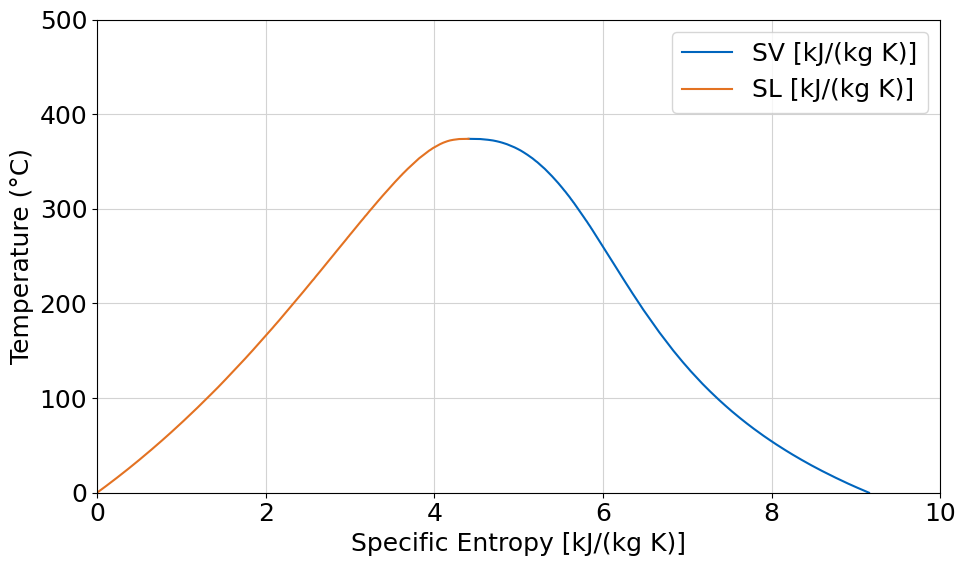

In [152]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plotting SL and SV against Temperature from steam tables
ax.plot(sv, temperature, label='SV [kJ/(kg K)]', color="#0065bd")
ax.plot(sl, temperature, label='SL [kJ/(kg K)]', color="#e37222")

# Setting axis limits
ax.set_xlim(0, 10)
ax.set_ylim(0, 500)

# Labels and title
ax.set_xlabel('Specific Entropy [kJ/(kg K)]')
ax.set_ylabel('Temperature (°C)')
plt.legend()

# Grid and layout
ax.grid(True, color="#D3D3D3")
plt.tight_layout()

fig.show()


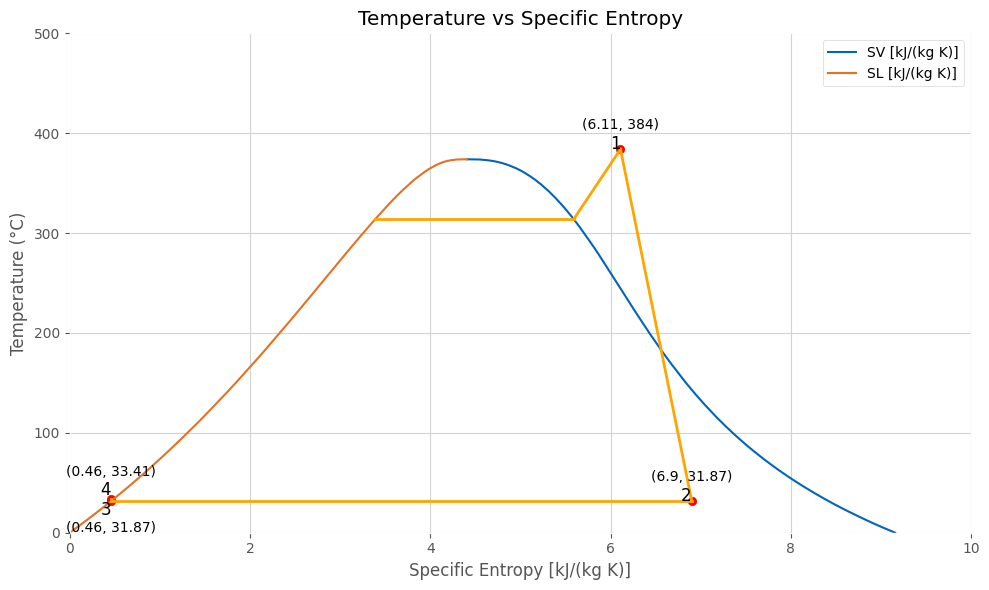

In [153]:
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle

with mplstyle.context('ggplot', after_reset=False):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.facecolor'] = 'white'
    # Plotting SL and SV against Temperature from steam tables
    plt.plot(sv, temperature, label='SV [kJ/(kg K)]', color="#0065bd")
    plt.plot(sl, temperature, label='SL [kJ/(kg K)]', color="#e37222")
    
    # Labeled points and intermediate points
    points = [(6.110, 384), (6.9, 31.87), (0.46, 31.87), (0.46, 33.41)]
    intermediate_points = [(3.389, 313.9), (5.591, 313.9)]
    labels = ['1', '2', '3', '4']
    
    # Plotting labeled points with red dots
    for i, ((x, y), label) in enumerate(zip(points, labels)):
        plt.scatter(x, y, color='red')
        if i == 2:  # For point 3
            plt.text(x, y, label, fontsize=12, ha='right', va='top')  # Label below
            plt.text(x, y - 20, f'({x}, {y})', fontsize=10, ha='center', va='top')  # Coordinates below
        elif i == 3:  # For point 4
            plt.text(x, y, label, fontsize=12, ha='right', va='bottom')  # Label above
            plt.text(x, y + 20, f'({x}, {y})', fontsize=10, ha='center', va='bottom')  # Coordinates above
        else:  # For other points
            plt.text(x, y, label, fontsize=12, ha='right')
            plt.text(x, y + 20, f'({x}, {y})', fontsize=10, ha='center')
    
    # Connecting the labeled points with lines
    for i in range(len(points) - 1):
        plt.plot([points[i][0], points[i + 1][0]], [points[i][1], points[i + 1][1]], color='orange', linestyle='-', linewidth=2)
    
    # Connecting the last point to the first point via intermediate points
    
    plt.plot([intermediate_points[0][0], intermediate_points[1][0]], [intermediate_points[0][1], intermediate_points[1][1]], color='orange', linestyle='-', linewidth=2)
    plt.plot([intermediate_points[1][0], points[0][0]], [intermediate_points[1][1], points[0][1]], color='orange', linestyle='-', linewidth=2)
    
    # Setting axis limits
    plt.xlim(0, 10)
    plt.ylim(0, 500)
    
    # Labels and title
    plt.xlabel('Specific Entropy [kJ/(kg K)]')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature vs Specific Entropy')
    plt.legend()
    
    # Grid and layout
    plt.grid(True, color="#D3D3D3")
    plt.tight_layout()
    
    # Show plot
    plt.savefig(r'figs\Cycle_simple.svg', format='svg', dpi=300)
    plt.show()

## 2. Rankine Cycle with Reheat

This following section presents an enhanced version of the Rankine cycle simulation, incorporating a reheat stage to improve efficiency and performance.

![Representation of the cycle under examination](figs/Rankine_complete.png)

In [154]:
rankine = Network()
rankine.set_attr(T_unit='C', p_unit='bar', h_unit='kJ / kg')

- **`sgre = SimpleHeatExchanger('steam generator for reheating')`:** This creates a new instance of a SimpleHeatExchanger component named `sgre`, representing a steam generator dedicated to reheating. Its purpose is to reheat the steam generated in the main steam generator before it enters the low-pressure turbine.

- **`tuhp = Turbine('steam turbine HP')` and `tulp = Turbine('steam turbine LP')`:** These lines create instances of Turbine components named `tuhp` and `tulp`, representing the high-pressure and low-pressure turbines, respectively. These turbines are responsible for converting the thermal energy of steam into mechanical work. The designation of HP and LP indicates their positions in the cycle, with the HP turbine operating on high-pressure steam and the LP turbine operating on low-pressure steam.

In [155]:
sgre = SimpleHeatExchanger('steam generator for reheating')
tuhp = Turbine('steam turbine HP')
tulp = Turbine('steam turbine LP')

c1 = Connection(cc, 'out1', tuhp, 'in1', label='1')
c2 = Connection(tuhp, 'out1', sgre, 'in1', label='2')
c3 = Connection(sgre, 'out1', tulp, 'in1', label='3')
c4 = Connection(tulp, 'out1', mc, 'in1', label='4')
c5 = Connection(mc, 'out1', fp, 'in1', label='5')
c6 = Connection(fp, 'out1', sg, 'in1', label='6')
c0 = Connection(sg, 'out1', cc, 'in1', label='0')

c11 = Connection(cwso, 'out1', mc, 'in2', label='11')
c12 = Connection(mc, 'out2', cwsi, 'in1', label='12')

rankine.add_conns(c1, c2, c3, c4, c5, c6, c0, c11, c12)

In [156]:
mc.set_attr(pr1=1, pr2=1)       # Pressure losses in the condenser
sg.set_attr(pr=0.9)             # Pressure losses in the heating process
sgre.set_attr(pr=0.946)         # Pressure losses in the reheating process
tuhp.set_attr(eta_s=0.80)       # HP Turbine isentropic efficiency
tulp.set_attr(eta_s=0.80)       # LP Turbine isentropic efficiency
fp.set_attr(eta_s=0.90)         # Feed pump isentropic efficiency

## 2.1 Define the new boundary condition for the cycle based on the table below.

Add them to the cycle by orienting yourself with the basic cycle.

| Andasol II               | HP turbine   | LP turbine     |
|--------------------------|--------------|----------------|
| Conditions at the inlet  | P = 104 bar  | P = 19.4 bar   |
|                          | T = 384 °C   | T = 383 °C |
|                          | ṁ = 54 kg/s  | ṁ = 54 kg/s    |
| Conditions at the outlet | P = 20.5 bar | P = 0.05 bar   |
|                          | T = 215 °C   | T = 30 °C      |

In [157]:
c11.set_attr(T=T_coo_in, p=1.2, fluid={'water': 1})
c12.set_attr(T=T_coo_out)
c1.set_attr(T=T_tu_in, m=mf, p=p_tu_in, fluid={'water': 1})
c3.set_attr(T=383, p=19.4)
c4.set_attr(p=p_tu_out)

In [158]:
powergen = Bus("electrical power output")

heat_input = Bus('heat input')
heat_input.add_comps({'comp': sg, 'base': 'bus'})
heat_input.add_comps({'comp': sgre, 'base': 'bus'})

powergen.add_comps(
    {"comp": tuhp, "char": 0.98 * 0.95, "base": "component"},     # eff_mecc = 0.98, eff_gen = 0.95
    {"comp": tulp, "char": 0.98 * 0.95, "base": "component"},
    {"comp": fp, "char": 0.95, "base": "bus"},                          # eff_el = 0.95
)

rankine.add_busses(heat_input, powergen)

In [159]:
rankine.set_attr(iterinfo=False)
rankine.solve(mode='design')
# rankine.print_results()

In [160]:
# Turbine Results
df_turbine = pd.DataFrame([
    {'name': 'steam turbine LP', 'P': tulp.P.val, 'eta_s': tulp.eta_s.val, 'pr': tulp.pr.val},
    {'name': 'steam turbine HP', 'P': tuhp.P.val, 'eta_s': tuhp.eta_s.val, 'pr': tuhp.pr.val}
])

# Simple Heat Exchanger Results
df_heat_exchanger = pd.DataFrame([
    {'name': 'steam generator', 'Q': sg.Q.val, 'pr': sg.pr.val, 'zeta': sg.zeta.val},
    {'name': 'steam generator for reheating', 'Q': sgre.Q.val, 'pr': sgre.pr.val, 'zeta': sgre.zeta.val}
])

# Condenser Results
df_condenser = pd.DataFrame([
    {'name': 'main condenser', 'Q': mc.Q.val, 'kA': mc.kA.val, 'ttd_u': mc.ttd_u.val, 
     'ttd_l': mc.ttd_l.val, 'pr1': mc.pr1.val, 'pr2': mc.pr2.val, 'zeta1': mc.zeta1.val, 'zeta2': mc.zeta2.val}
])


# Pump Results
df_pump = pd.DataFrame([
    {'name': 'feed pump', 'P': fp.P.val, 'eta_s': fp.eta_s.val, 'pr': fp.pr.val}
])

# Connections Results
df_connections = pd.DataFrame([
    {'label': '1', 'm': c1.m.val, 'p': c1.p.val, 'h': c1.h.val, 'T': c1.T.val},
    {'label': '2', 'm': c2.m.val, 'p': c2.p.val, 'h': c2.h.val, 'T': c2.T.val},
    {'label': '3', 'm': c3.m.val, 'p': c3.p.val, 'h': c3.h.val, 'T': c3.T.val},
    {'label': '4', 'm': c4.m.val, 'p': c4.p.val, 'h': c4.h.val, 'T': c4.T.val},
    {'label': '5', 'm': c5.m.val, 'p': c5.p.val, 'h': c5.h.val, 'T': c5.T.val},
    {'label': '6', 'm': c6.m.val, 'p': c6.p.val, 'h': c6.h.val, 'T': c6.T.val},
    {'label': '11', 'm': c11.m.val, 'p': c11.p.val, 'h': c11.h.val, 'T': c11.T.val},
    {'label': '12', 'm': c12.m.val, 'p': c12.p.val, 'h': c12.h.val, 'T': c12.T.val}
])

# Buses Results for heat input
df_buses_heat_input = pd.DataFrame([
    {'name': 'steam generator', 'component value': sg.Q.val, 'bus value': 1.558e+08, 'efficiency': 1.000},
    {'name': 'steam generator for reheating', 'component value': sgre.Q.val, 'bus value': 2.442e+07, 'efficiency': 1.000},
    {'name': 'total', 'component value': 1.803e+08, 'bus value': 1.803e+08, 'efficiency': None}
])

# Buses Results for electrical power output
df_buses_electric_output = pd.DataFrame([
    {'name': 'steam turbine HP', 'component value': tuhp.P.val, 'bus value': -1.392e+07, 'efficiency': 9.310e-01},
    {'name': 'steam turbine LP', 'component value': tulp.P.val, 'bus value': -4.226e+07, 'efficiency': 9.310e-01},
    {'name': 'feed pump', 'component value': fp.P.val, 'bus value': 7.316e+05, 'efficiency': 9.500e-01},
    {'name': 'total', 'component value': -5.965e+07, 'bus value': -5.545e+07, 'efficiency': None}
])

# Display DataFrames
print("Turbine DataFrame")
print(df_turbine)

print("\nHeat Exchanger DataFrame")
print(df_heat_exchanger)

print("\nCondenser DataFrame")
print(df_condenser)

print("\nPump DataFrame")
print(df_pump)

print("\nConnections DataFrame")
print(df_connections)

print("\nBuses Heat Input DataFrame")
print(df_buses_heat_input)

print("\nBuses Electrical Power Output DataFrame")
print(df_buses_electric_output)

Turbine DataFrame
               name             P  eta_s        pr
0  steam turbine LP -4.539453e+07    0.8  0.002577
1  steam turbine HP -2.098054e+07    0.8  0.197187

Heat Exchanger DataFrame
                            name             Q     pr          zeta
0                steam generator  1.807550e+08  0.900  27785.943629
1  steam generator for reheating  5.536633e+06  0.946    330.359357

Condenser DataFrame
             name             Q            kA     ttd_u      ttd_l  pr1  pr2  \
0  main condenser -1.206115e+08  1.083098e+07  6.874255  16.874255  1.0  1.0   

   zeta1  zeta2  
0    0.0    0.0  

Pump DataFrame
        name              P  eta_s           pr
0  feed pump  694983.510563    0.9  2311.111111

Connections DataFrame
  label            m           p            h           T
0     1    54.000000  104.000000  3497.932613  550.000000
1     2    54.000000   20.507400  3109.404008  337.895854
2     3    54.000000   19.400000  3211.934250  383.000000
3     4    54.

## 2.2 Calculate the cycle efficiency


In [161]:
# Calculate net work output (electrical power generated by the turbine)
W_net = abs(powergen.P.val)  # Taking absolute value to ensure positive net work

# Calculate heat input to the cycle (heat supplied to the steam generator)
Q_in = sg.Q.val

# Calculate thermal efficiency of the cycle
thermal_efficiency = W_net / Q_in

print(f"Thermal efficiency of the cycle with reheat: {round(thermal_efficiency * 100, 2)} %")

Thermal efficiency of the cycle with reheat: 33.78 %


## 2.3 Calculate the efficiency including the power required for wet and dry cooling

Assume the condensation temperature is equal in both cases:
- **Power Block Parasitics:**
  - **Wet Cooling:** 1679 kW
  - **Dry Cooling:** 2729 kW

In [162]:
# Calculate net work output (electrical power generated by the turbine)
W_net = abs(powergen.P.val)  # Taking absolute value to ensure positive net work

# Calculate heat input to the cycle (heat supplied to the steam generator)
Q_in = sg.Q.val

# Calculate thermal efficiency of the cycle
thermal_efficiency = (W_net - 1.679e6) / Q_in

print(f"Thermal efficiency of the cycle with reheat (wet cooling): {round(thermal_efficiency * 100, 2)} %")

Thermal efficiency of the cycle with reheat (wet cooling): 32.85 %


In [163]:
# Calculate net work output (electrical power generated by the turbine)
W_net = abs(powergen.P.val)  # Taking absolute value to ensure positive net work

# Calculate heat input to the cycle (heat supplied to the steam generator)
Q_in = sg.Q.val

# Calculate thermal efficiency of the cycle
thermal_efficiency = (W_net - 2.729e6) / Q_in

print(f"Thermal efficiency of the cycle with reheat (dry cooling): {round(thermal_efficiency * 100, 2)} %")

Thermal efficiency of the cycle with reheat (dry cooling): 32.27 %


## 2.4 What other factors are reducing the overall efficiency with dry cooling?

- The higher back pressure in dry cooling systems reduces the thermodynamic efficiency of the Rankine cycle.
- Higher condensation temperature reduces delta T.

## 2.5 Draw the T-s Diagram for the reheat cycle

In [164]:
# Load the Excel file into a Pandas DataFrame
file_path = 'data\Steamtables.xlsx'
df_steam = pd.read_excel(file_path, sheet_name='Tabelle1')

# Extracting the data from steam tables
temperature = df_steam['T (°C)']
sv = df_steam['SV [kJ/(kg K)]']
sl = df_steam['SL [kJ/(kg K)]']

# New data with entropy values for specific states
data_states = {
    'State': [1, 2, 3, 4, 5, 6],
    'm': [54.0, 54.0, 54.0, 54.0, 54.0, 54.0],
    'p': [104.0, 20.51, 19.4, 0.05, 0.05, 115.6],
    'h': [3036.0, 2760.0, 3212.0, 2371.0, 137.7, 150.6],
    'T': [384.0, 213.6, 383.0, 32.87, 32.87, 32.87],
    's': [6.106, 6.25, 7.089, 7.774, 0.47889, 0.4804]
}

# Create DataFrame for the states data
df_states = pd.DataFrame(data_states)

# Extracting the temperature and entropy data for states
temperature_states = df_states['T']
entropy_states = df_states['s']

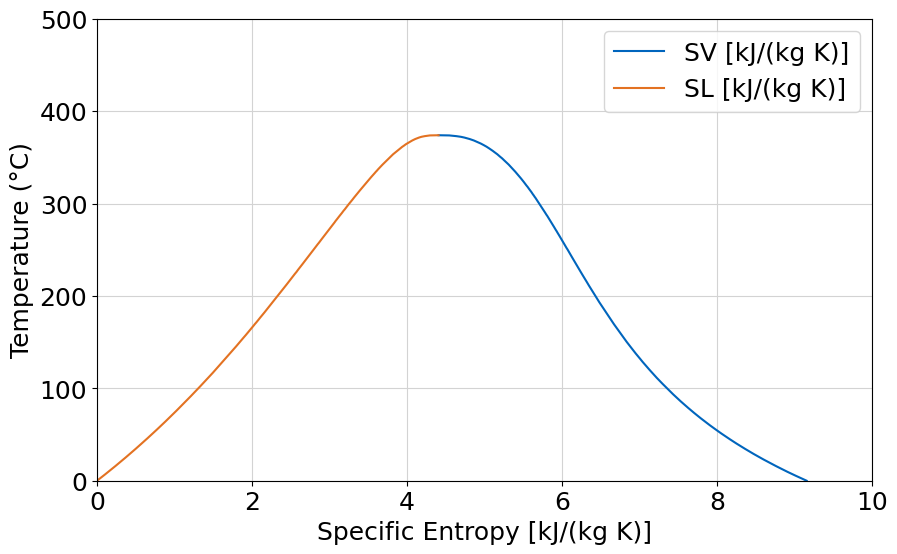

In [165]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting SL and SV against Temperature from steam tables
ax.plot(sv, temperature, label='SV [kJ/(kg K)]', color="#0065bd")
ax.plot(sl, temperature, label='SL [kJ/(kg K)]', color="#e37222")

# Setting axis limits
ax.set_xlim(0, 10)
ax.set_ylim(0, 500)

# Labels and title
ax.set_xlabel('Specific Entropy [kJ/(kg K)]')
ax.set_ylabel('Temperature (°C)')
plt.legend()

ax.grid(True, color="#D3D3D3")


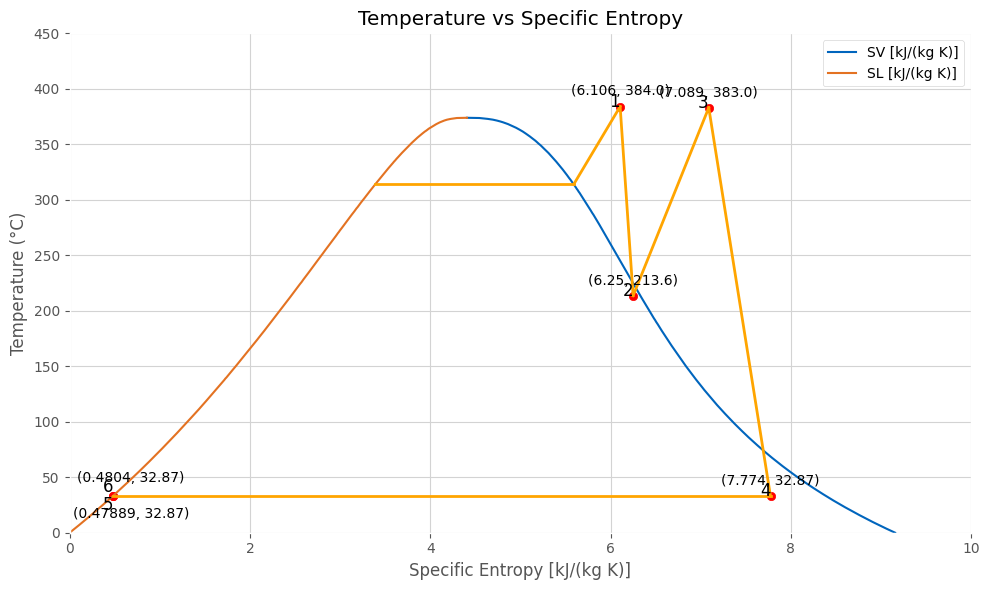

In [166]:

with mplstyle.context('ggplot', after_reset=False):
    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.facecolor'] = 'white'
    # Plotting SV against Temperature from steam tables
    plt.plot(sv, temperature,
             label='SV [kJ/(kg K)]', color="#0065bd")
    
    # Plotting SL against Temperature from steam tables
    plt.plot(sl, temperature,
             label='SL [kJ/(kg K)]', color="#e37222")
    
    # Extracting points (entropy and temperature) and labels for states
    points = list(zip(entropy_states, temperature_states))
    labels = df_states['State']
    
    # Intermediate points for connecting lines (example points; adjust as needed)
    intermediate_points = [(5.591, 313.9), (3.389, 313.9)]
    
    # Plotting labeled points with red dots for states
    for i, (x, y) in enumerate(points):
        plt.scatter(x, y, color='red')  # Plotting red dots for each point
        # Adding labels and coordinates
        if labels[i] == 5:
            plt.text(x, y, f'{labels[i]}',
                     fontsize=12, ha='right', va='top')  # Label above point 5
            plt.text(x+0.2, y - 10, f'({x}, {y})',
                     fontsize=10, ha='center', va='top')  # Coordinates below point 5
        elif labels[i] == 6:
            plt.text(x, y, f'{labels[i]}',
                     fontsize=12, ha='right', va='bottom')  # Label below point 6
            plt.text(x+0.2, y + 10, f'({x}, {y})',
                     fontsize=10, ha='center', va='bottom')  # Coordinates above point 6
        else:
            plt.text(x, y, f'{labels[i]}', fontsize=12, ha='right')  # Label for other points
            plt.text(x, y + 10, f'({x}, {y})', fontsize=10, ha='center')  # Coordinates for other points
    
    # Connecting the labeled points with lines for states
    for i in range(len(points) - 1):
        plt.plot([points[i][0], points[i + 1][0]],
                 [points[i][1], points[i + 1][1]],
                 color='orange', linestyle='-', linewidth=2)
    
    # Connecting the first intermediate point to the second
    plt.plot([intermediate_points[0][0], intermediate_points[1][0]],
             [intermediate_points[0][1], intermediate_points[1][1]],
             color='orange', linestyle='-', linewidth=2)
    
    # Connecting Intermediate 1 to point 1
    plt.plot([intermediate_points[0][0], points[0][0]], [intermediate_points[0][1], points[0][1]],
             color='orange', linestyle='-', linewidth=2)
    
    # Setting axis limits for better visualization
    plt.xlim(0, 10)
    plt.ylim(0, 450)
    
    # Adding labels for axes and title
    plt.xlabel('Specific Entropy [kJ/(kg K)]')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature vs Specific Entropy')
    
    # Adding legend to the plot
    plt.legend()
    
    # Adding grid for better readability
    plt.grid(True, color="#D3D3D3")
    
    # Adjusting layout for better fit
    plt.tight_layout()
    
    # Displaying the plot
    plt.savefig(r'figs\Cycle_reheated.svg', format='svg', dpi=300)
    plt.show()

## Excurse: advantages of having a simulation

Having a simulation of a cycle allows to do parameteric studies with ease.

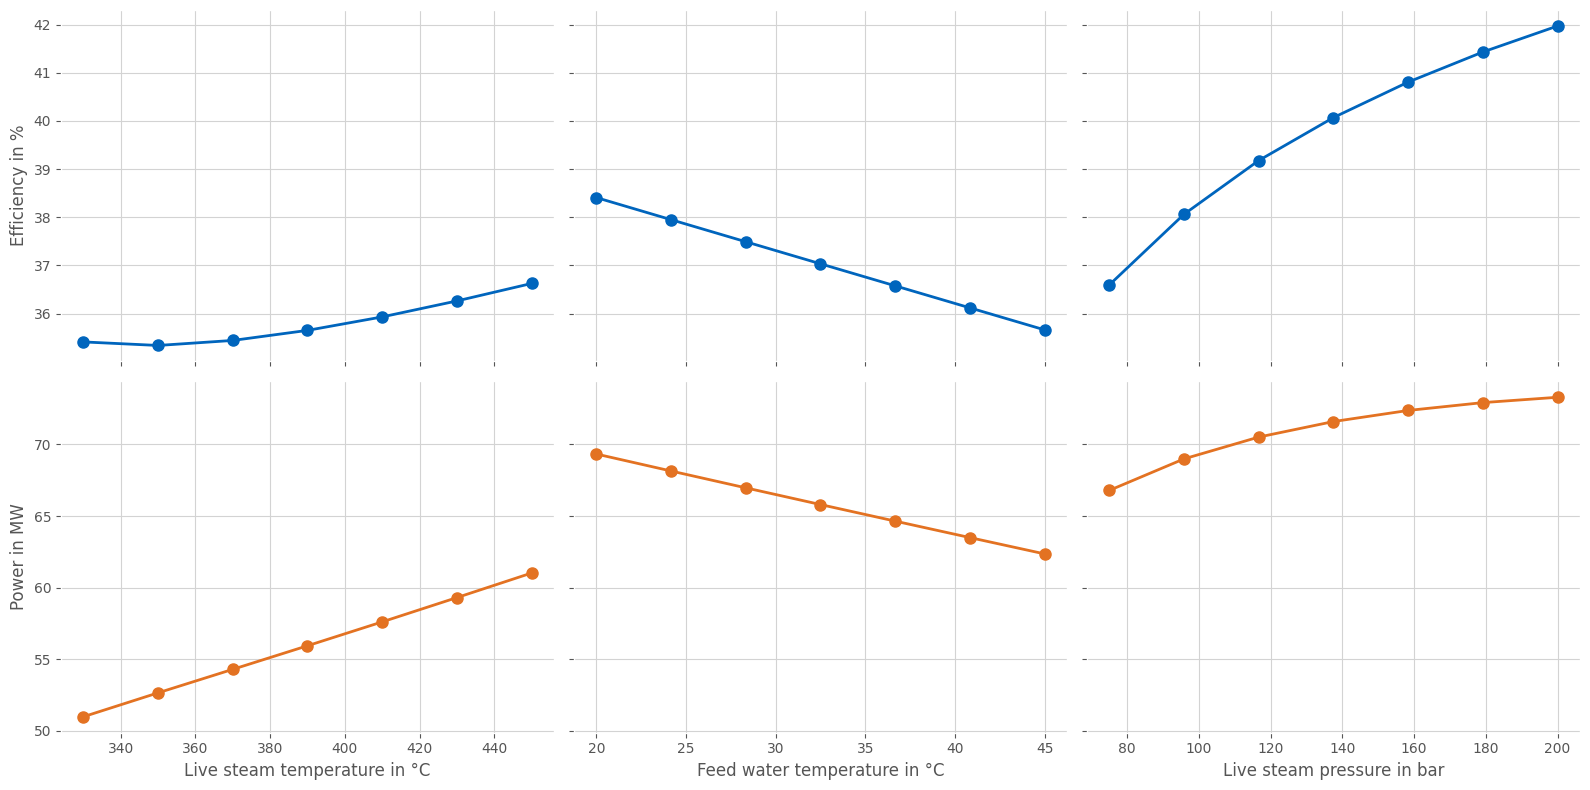

In [167]:
import numpy as np

rankine.set_attr(iterinfo=False)

# make text reasonably sized
plt.rc('font', **{'size': 18})

data = {
    'T_livesteam': np.linspace(330, 450, 7),
    'T_cooling': np.linspace(20, 45, 7),
    'p_livesteam': np.linspace(75, 200, 7)
}
eta = {
    'T_livesteam': [],
    'T_cooling': [],
    'p_livesteam': []
}
power = {
    'T_livesteam': [],
    'T_cooling': [],
    'p_livesteam': []
}

for T in data['T_livesteam']:
    c1.set_attr(T=T)
    c3.set_attr(T=T-1)
    rankine.solve('design')
    eta['T_livesteam'] += [abs(powergen.P.val) / sg.Q.val * 100]
    power['T_livesteam'] += [abs(powergen.P.val) / 1e6]

# reset to base temperature
c1.set_attr(T=T_tu_in)
c3.set_attr(T=T_tu_in-1)
mc.set_attr(ttd_u=4)        # Set to a DT of 4 otherwise conflicts in the condenser
c4.set_attr(p=None)

for T in data['T_cooling']:
    c12.set_attr(T=T + 10)
    c11.set_attr(T=T)
    rankine.solve('design')
    eta['T_cooling'] += [abs(powergen.P.val) / sg.Q.val * 100]
    power['T_cooling'] += [abs(powergen.P.val) / 1e6]

# reset to base temperature and pressure output
mc.set_attr(ttd_u=None)
c12.set_attr(T=T_coo_out)
c11.set_attr(T=T_coo_in)
c4.set_attr(p=p_tu_out)

for p in data['p_livesteam']:
    c1.set_attr(p=p)
    rankine.solve('design')
    eta['p_livesteam'] += [abs(powergen.P.val) / sg.Q.val * 100]
    power['p_livesteam'] += [abs(powergen.P.val) / 1e6]

# reset to base pressure
c1.set_attr(p=p_tu_in)

with mplstyle.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex='col', sharey='row')    
    ax = ax.flatten()
    [a.grid() for a in ax]
    
    i = 0
    for key in data:
        # Plotting lines
        ax[i].plot(data[key], eta[key], marker='o', linestyle='-', color="#0065bd", markersize=8,
            linewidth=2)
        ax[i].set_facecolor('white')
        ax[i].grid(True, color="#D3D3D3")
        ax[i + 3].plot(data[key], power[key], marker='o', linestyle='-', color="#e37222", markersize=8,
            linewidth=2)
        ax[i + 3].set_facecolor('white')
        ax[i + 3].grid(True, color="#D3D3D3")
        i += 1
        
    ax[0].set_ylabel('Efficiency in %')
    ax[3].set_ylabel('Power in MW')
    ax[3].set_xlabel('Live steam temperature in °C')
    ax[4].set_xlabel('Feed water temperature in °C')
    ax[5].set_xlabel('Live steam pressure in bar')
    plt.tight_layout()
    plt.savefig(r"figs\Boundaries.svg", format='svg', dpi=300)
    plt.show()